In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import scipy.interpolate
import os
import sys
%matplotlib notebook

def label_axes(ax, text):
    """Add a label (e.g. (a)) to the corner of the axes."""
    

# Loading data
The data starts off as two folders of JPEG files, containing images of an edge that is scanned over the field of view.  The two folders correspond to horizontal and vertical edges. Another script has processed these into numpy archives containing the coordinates of the lines.  

In [2]:
data_folder = (r"X:\Physics\ResearchProjects\RWBowman\rwb34 - R Bowman\projects\openflexure\experiments"
     + r"\20170928_resolution_tests\datasets\ac127_100x_plan")
liness = [None, None]
positionss = [None, None]

for direction_folder in ["distortion_h", "distortion_v"]: # one folder for each edge direction - doesn't matter which
    data = np.load(os.path.join(data_folder,direction_folder,"lines.npz")) # cache the image analysis for speed's sake - allows us to repeat the later stuff easily
    lines = data['lines']
    positions = data['stage_positions']

    changing_axis = np.argmax(np.std(np.mean(lines, axis=2), axis=0)) # the axis that changes is the interesting one - e.g. y for horizontal lines
    liness[changing_axis] = lines
    positionss[changing_axis] = positions

``liness`` is a list containing two numpy arrays, the axes of which are:
1. image (i.e. which line, corresponding different positions of the edge)
2. axis (x or y, always of length 2)
3. pixel (one of x or y will simply be zero to N, while the other is roughly constant, at the position of the edge)
``positionss`` has the same structure, but missing the last axis.  It contains the stage coordinates corresponding to the motion of the edge (it's used to estimate step size).

The lines will contain some bad ones - usually where the edge has moved off the end of the field of view.  We look at the differential variance of the line to estimate which ones are reasonable (reasonable ones will have a low variance between adjacent points, because the lines are nearly straight).

<IPython.core.display.Javascript object>


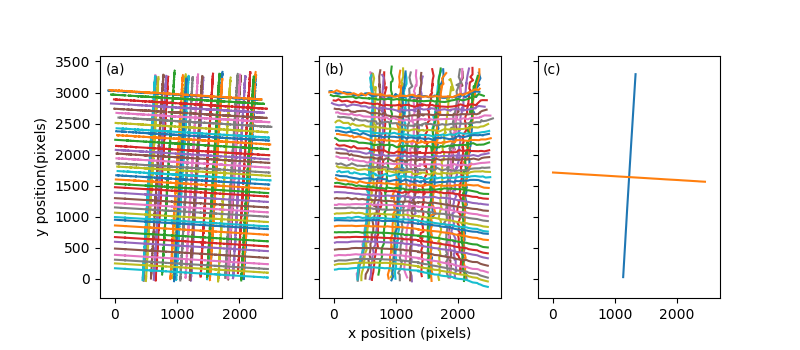

In [119]:
def reduce_1d(x, blocksize, axis=None):
    """Take block means of a 1D array"""
    if axis is None and len(x.shape) == 1:
        N = len(x)//blocksize
        # We reshape so that we can take block means by taking means of columns.
        return np.mean(x[:(N*blocksize)].reshape(N, blocksize), axis=1)
    else:
        shape = x.shape
        # Crop the array so it reshapes exactly into an integer number of blocks
        N = shape[axis]//blocksize
        crop_slice = ((slice(None),)*(axis)
                      + (slice(0,N*blocksize),) 
                      + (slice(None),)*(len(shape) - axis - 1))
        # then reshape it so the axis in question becomes 2 axes
        new_shape = shape[:axis] + (N, blocksize) + shape[(axis + 1):]
        # the second of these new axes will be the one over which we take the mean
        return np.mean(x[crop_slice].reshape(new_shape), axis=axis+1)

def widen(x, axis=0):
    """widen a boolean array by 1 along the given axis, using a logical OR"""
    shape = list(x.shape)
    shape[axis] += 1
    out = np.zeros(shape, dtype=np.bool)
    slices = [slice(None)] * len(shape)
    slices[axis] = slice(None, -1)
    out[slices] = x
    slices[axis] = slice(1, None)
    out[slices] = np.logical_or(out[slices], x)
    return out

camera_centre = [(l.shape[2]-1)/2 for l in reversed(liness)] # this is the centre of the camera

masked_liness = [None, None] # "lines" holds all the lines from one folder.  "liness" is a list, holding *both* folders.
threshold = 3
for i in range(len(liness)):
    # calculate the differential variance of each line, smooth it, and set a threshold for "too noisy"
    noisiness = np.sqrt(np.sum(ndimage.filters.gaussian_filter1d(np.diff(liness[i], axis=2)**2, 2, axis=2), axis=1))
    mask = widen(noisiness > threshold, axis=1) # we need to widen the array because the diff() shrank it
    masked_liness[i] = np.ma.masked_array(liness[i], np.tile(mask[:, np.newaxis, :], (1,2,1))) # need to restore axis 1, of length 2

def plot_lines(ax, lines, deviations=None, reduction=1):
    """Plot lines, first making all the lines the same shape, then adding some deviation to them."""
    line_centres = np.mean(lines, axis=2)
    mean_line = np.mean(lines - line_centres[:,:,np.newaxis], axis=0)
    uniform_lines = line_centres[:,:,np.newaxis] + mean_line[np.newaxis,:,:]
    if deviations is None:
        deviations = np.zeros_like(lines)
    for i in range(lines.shape[0]):
        ax.plot(reduce_1d(line_centres[i,0] + mean_line[0,:] + deviations[i,0,:], reduction),
                reduce_1d(line_centres[i,1] + mean_line[1,:] + deviations[i,1,:], reduction))
    
deviationss = []
mean_lines = []
gain = 20
fig, axes = plt.subplots(1,3,figsize=(8,3.5), sharex=True, sharey=True)
for i, lines in enumerate(masked_liness):
    # First, calculate the mean line shape.  NB we have to subtract each line's position, otherwise masking elements
    # of different lines will add noise (effectively by weighting edge positions differently for different pixels)
    # subtracting the mean of each line should (more or less) fix this by making all the lines coincident before
    # averaging them together.
    # of course, the mean position will be affected by masked elements if lines aren't perfectly straight - but
    # this shouldn't be a big effect as the lines are nearly vertical.  If the mean lines in the plot are straight,
    # that means it's ok - 
    mean_line = (lines - lines.mean(axis=2)[:,:,np.newaxis]).mean(axis=0)
    mean_lines.append(mean_line)
    axes[2].plot(reduce_1d(mean_line[0,:] + camera_centre[0], 10), 
                 reduce_1d(mean_line[1,:] + camera_centre[1],10))
    
    deviations = lines - mean_line[np.newaxis,...] # remove the average line shape
    deviations -= deviations.mean(axis=2)[:,:,np.newaxis] # remove the positions of individual lines
    deviationss.append(deviations)
    plot_lines(axes[0], lines)
    plot_lines(axes[1], lines, deviations*gain, reduction=50)

        
def tidy_pixel_axes(axes, 
                    label_pos=(0.03,0.97), 
                    va="top", ha="left", 
                    xlabels=None, ylabels=[0], 
                    aspect=1, 
                    part_number_offset=0,
                    xlabel="x position (pixels)", ylabel="y position(pixels)"):
    """For a series of axes with shared X and Y, ensure the aspects are equal, limits are tight, and label them.
    
    label_pos should be a tuple of two numbers setting the position of (a), (b), ... "part labels" in axis coords.
    va and ha set the alignment of the above labels
    xlabels and ylabels should be lists of integers specifying which axes have x axis and y axis labels.  Leave as
        None to label the middle axis, or True to label all axes
    aspect (if not None) sets the aspect of the plot - defaults to 1
    part_number_offset starts the figure part labels from later in the sequence - e.g. if it's 3, then we start at (d).
    """
    for i, ax in enumerate(axes):
        ax.set_adjustable('box-forced') # avoid extraneous whitespace (https://github.com/matplotlib/matplotlib/issues/1789/)
        if aspect is not None:
            ax.set_aspect(aspect) # X and Y are both in pixels - so make sure it's isotropic.
        if label_pos is not False:
            ax.text(label_pos[0], label_pos[1], "(" + chr(i+97+part_number_offset) + ")", va=va, ha=ha, transform=ax.transAxes)
    if xlabels is None:
        xlabels = [len(axes)//2]
    if xlabels is True:
        xlabels = range(len(axes))
    if ylabels is True:
        ylabels = range(len(axes))
    if xlabel is not None:
        for i in xlabels:
            axes[i].set_xlabel(xlabel)
    if ylabel is not None:
        for i in ylabels:
            axes[i].set_ylabel(ylabel)
    
#for ax, title, part in zip(axes, ["As recovered", "Deviations x{}".format(gain), "Mean line shapes"], ["({})".format(a) for a in "abc"]):
    #ax.set_title(title)
#    ax.text(0.03,0.97,part,va="top",ha="left",transform=ax.transAxes)

tidy_pixel_axes(axes)
f.tight_layout()

**Figure ?**: (a) Lines fitted to images of an edge, scanned across the field of view and (b) the same lines with distortion multiplied 20x, relative to the mean line shapes (c).

Lens distortion is probably radial, i.e. it distorts the distance, but not the angle, from some centre point (which probably isn't the centre of the image, though it ought to be close).  It would be good to fit this, and model how much of the distortion can be ascribed to a purely radial function about some centre.  This next cell defines a function that will model the distortion that results from a given radial distortion function.  We can use the deviation between this and the actual distortion as a cost function, and minimise to find the right parameters.  The radial distortion, assuming it's small compared to the radius, is:

$\Delta r = f(r)$ where $r = \sqrt{(x - c_x)^2 + (y - c_y)^2 }$.

We'll optimise for both the centre position $(c_x, c_y)$ and for the function $f(r)$.

The radial distortion function is defined by spline-interpolating a number of points, defined as being evenly spaced between $r=0$ and $r=r_{max}$ where $r_{max}$ is half the length of the image's diagonal (if the centre moves to the edge of the image, extrapolation will be used if $r>r_{max}$).

<IPython.core.display.Javascript object>


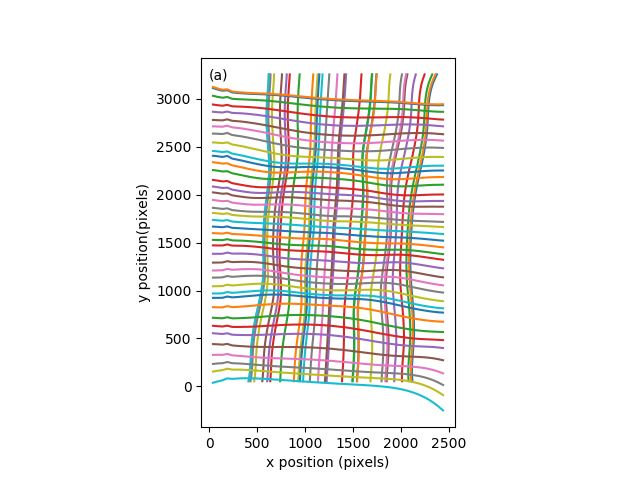

In [158]:
import scipy.interpolate

def make_dr_spline(dr, liness):
    """Construct a spline to use as a radial distortion function."""
    dr = np.concatenate([[0.], dr]) #fix the centre as zero distortion
    # we model the radial distortion as a function of radius, using cubic interpolation
    # the "x axis" of the function goes from zero to half the diagonal (points beyond are interpolated)
    modelled_deviationss_max_r = np.sqrt(np.sum([np.max(l[:,(i+1)%2,:])**2 
                                                 for i, l in enumerate(liness)]))/2 # half the diagonal
    dr_spline = scipy.interpolate.interp1d(np.linspace(0,modelled_deviationss_max_r,len(dr)),
                                      dr, kind="cubic", bounds_error=False, fill_value="extrapolate")
    def wrapped_dr_spline(radii):
        if isinstance(radii, np.ma.MaskedArray):
            # the spline interpolation fails with a masked array, so unmask-interpolate-remask...
            return np.ma.array(dr_spline(np.ma.filled(radii, 0)), mask=radii.mask)
        else:
            return dr_spline(radii)
            
    return wrapped_dr_spline
    
def modelled_deviationss(centre, dr, liness):
    """Calculate the deviation-from-the-mean lines for a given distortion function
    
    centre: np.array, length 2, describing the centre of distortion in pixels
    """
    deviationss = []
    dr_spline = make_dr_spline(dr, liness)
    
    centre = np.array(centre)
    for i, lines in enumerate(liness):
        pos = lines - centre[np.newaxis,:,np.newaxis] #positions relative to centre
        radii = np.sqrt(np.sum(pos**2, axis=1)) #radii, for each point on each line
        dr = dr_spline(radii)
        deviations = dr[:,np.newaxis,:] * pos/radii[:,np.newaxis,:] # NB this is the "true" deviation in r, not what we measure
        deviations[:,(i + 1) % 2, :] = 0 # We can't measure anything along the axis of the deviation, so zero it out
                                         # NB there's an approximation here because the edge isn't perfectly along x or y...
        deviationss.append(deviations)
    return deviationss
        
    
md = modelled_deviationss(camera_centre, [0,0,-0.3,0,0.3,0.4,1.8], reduced_liness)
gain = 200
f, ax = plt.subplots(1,1)
for lines, deviations in zip(reduced_liness, md):
    plot_lines(ax, lines, deviations*gain)
tidy_pixel_axes([ax])

The graph above shows modelled deviations, essentially reproducing (b) from the previous figure with arbitrary coefficients in the distortion function.

Next, we optimise to find the centre position and radial distortion function that best fit the measured deviations from the mean:

In [161]:
import scipy.optimize

# Work at reduced resolution, to decrease noise and increase speed...
reduction = 50
reduced_liness, reduced_deviationss = [], []
for lines, deviations in zip(liness, deviationss):
    reduced_liness.append(reduce_1d(lines, 50, axis=2))
    reduced_deviationss.append(reduce_1d(deviations, 50, axis=2))

def cost_function(coeffs, centre=None):
    """Return the error between calculated and actual deviations.  
    
    The first two elements of coeffs are interpreted as the centre, the rest define the radial distortion function.
    ``deviationss``, ``modelled_deviations_max_r``, and ``modelled_deviations_normals`` are used but not passed as arguments.
    """
    if centre is None:
        mdevss = modelled_deviationss(coeffs[:2], coeffs[2:], reduced_liness)
    else:
        mdevss = modelled_deviationss(centre, coeffs, reduced_liness)
    cost = 0
    for devs, mdevs in zip(reduced_deviationss, mdevss):
        #w = np.ones(mdevs.shape[2])
        #w[:1] = 0
        #w[-1:] = 0
        # NB we're not sensitive to distortion that appears to move the whole line, so we
        # subtract the mean of each line, to get rid of shifts like that.  Otherwise, it acts
        # as a built-in penalty for large distortions.
        cost += np.var((mdevs - devs) - np.mean(mdevs - devs, axis=2)[:,:,np.newaxis])#*w[np.newaxis, np.newaxis, :])
    return cost

res = scipy.optimize.minimize(cost_function, np.array(camera_centre + [0]*4))

<IPython.core.display.Javascript object>


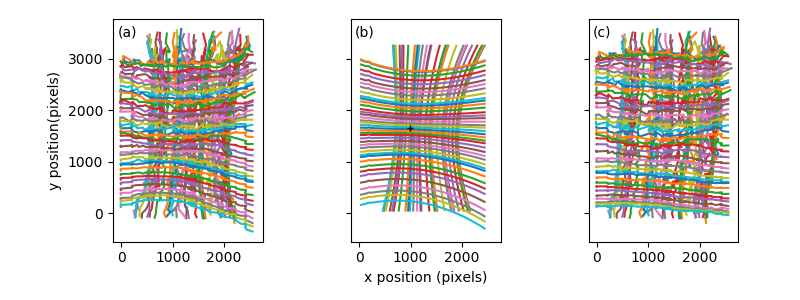

In [162]:
md = modelled_deviationss(res.x[:2], res.x[2:], reduced_liness)
gain = 50
fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(8,3))
for lines, deviations, model in zip(reduced_liness, reduced_deviationss, md):
    plot_lines(axes[0], lines, deviations*gain)
    plot_lines(axes[1], lines, model*gain)
    plot_lines(axes[2], lines, (deviations-model)*gain)
axes[1].plot(res.x[0], res.x[1], "+", markersize=5.0, color="black")
tidy_pixel_axes(axes)
fig.tight_layout()

(a) the measured lines, with deviations from the mean line shape amplified by a factor of 50, the modelled deviations (b) plotted in the same way, and the difference between measured and modelled deviations (c).

In [163]:
# double-check that the recovered centre really is the best, by forcing a brute-force search of the centre.
N = 9
width = 800
results = []
for i, dx in enumerate(np.linspace(-width,width,N)):
    row = []
    for j, dy in enumerate(np.linspace(-width,width,N)):
        centre = np.array(camera_centre) + np.array([dx, dy])
        row.append(scipy.optimize.minimize(cost_function, np.array([0.] * 4), args=(centre,)))
    results.append(row)
    

<IPython.core.display.Javascript object>


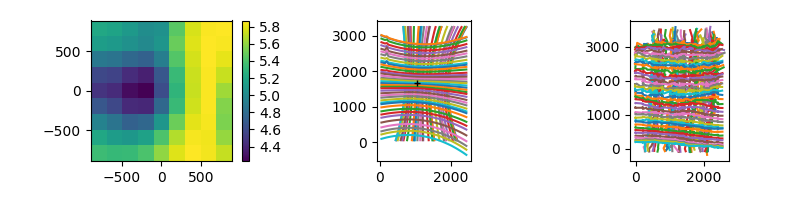

In [164]:
# plot the results of manually setting the centre, and allow interactive repositioning of the centre
costs = np.array([[r.fun for r in row] for row in results])
f, axes = plt.subplots(1,3, figsize=(8,2))
im = axes[0].imshow(costs.T, aspect=1,extent=np.array((-1,1,-1,1))*width*(N+1)/N, origin="bottom")
f.colorbar(im, ax=axes[0])
for ax in axes[1:]:
    ax.set_aspect(1)
f.tight_layout()
gain = 50

def onclick(event):
    click = np.array([event.xdata, event.ydata])
    centre = click + camera_centre
    r = scipy.optimize.minimize(cost_function, np.array([0.] * 4), args=(centre,))
    md = modelled_deviationss(centre, r.x, reduced_liness)
    for ax in axes[1:]:
        ax.cla()
    for lines, deviations, model in zip(reduced_liness, reduced_deviationss, md):
        dd = deviations - model
        for j in range(lines.shape[0]):
            axes[1].plot(lines[j,0,:]-deviations[j,0,:] + model[j,0,:]*gain, 
                         lines[j,1,:]-deviations[j,1,:] + model[j,1,:]*gain)
            axes[2].plot(lines[j,0,:]-deviations[j,0,:] + dd[j,0,:]*gain, 
                         lines[j,1,:]-deviations[j,1,:] + dd[j,1,:]*gain)
    axes[1].plot(centre[0], centre[1], "+", markersize=5.0, color="black")

cid = f.canvas.mpl_connect('button_press_event', onclick)

The above plot shows the residual error after optimisation, as the centre is manually fixed in different places (the offset is in pixels, relative to the image's centre).  The minimum should show the best position of the centre - which should agree with what the optimiser recovers when it's free to move the centre around.  The two plots on the right show the modelled distortion and the residual distortion, where the centre is positioned by clicking on the image plot (this requires interactive plotting with ``%matplotlib notebook``).

An alternative presentation: calculate the radial distortion function from the measured distortion, so we can display them together.  NB this involves scaling up the distortions near the image centre, which increases the noise on the measured data.  Happily the way the errors are calculated means that we're not hyper-sensitive to this noise when optimising.

<IPython.core.display.Javascript object>


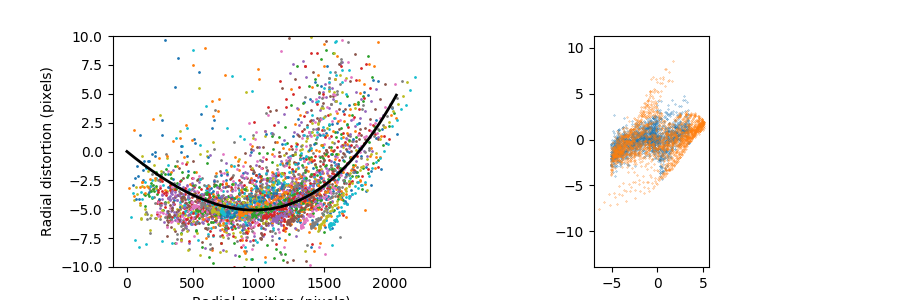

In [168]:
fig, axes = plt.subplots(1,2, figsize=(9,3))
dr_points = np.concatenate([[0.], res.x[2:]])
dr_spline = scipy.interpolate.interp1d(np.linspace(0,modelled_deviationss_max_r,len(dr_points)),
                                       dr_points, kind="cubic", bounds_error=False, fill_value="extrapolate")
centre = np.array(res.x[:2])
for i, (lines, deviations) in enumerate(zip(liness, deviationss)):
    pos = lines - centre[np.newaxis,:,np.newaxis] #positions relative to centre
    radii = np.sqrt(np.sum(pos**2, axis=1)) #radii, for each point on each line
    dr = deviations[:,i,:] * radii / pos[:,i,:]
    dr += np.mean(dr_spline(radii))
    for j in range(radii.shape[0]):
        axes[0].plot(reduce_1d(radii[j,:], 50), reduce_1d(dr[j,:], 50), '.', markersize=2.0)
radii = np.linspace(0, modelled_deviationss_max_r, 200)
axes[0].plot(radii, dr_spline(radii), '-', linewidth=2, color="black")
axes[0].set_ylim((-10,10))
axes[0].set_ylabel("Radial distortion (pixels)")
axes[0].set_xlabel("Radial position (pixels)")

md = modelled_deviationss(res.x[:2], res.x[2:], reduced_liness)
for i in range(2):
    axes[1].plot(md[i][:,i,:].flatten(), reduced_deviationss[i][:,i,:].flatten(), ".", markersize=0.5)
axes[1].set_ylim(np.array(axes[1].get_xlim())*2)
axes[1].set_aspect(1)

Plotting the radial distortion as a function of radius, with the fitted distortion shown as a line, and measured distortions shown as points.  N.B. the transformation required to show measured points on this graph exaggerates the noise present on points close to the centre of the image.

**TODO** the errors above look worse than they are, because the mean of each line is zero.  Maybe I should shift the means of the lines using the radial function...

The same information can be represented by image plots, though it's easier to separate out X and Y in that case:

<IPython.core.display.Javascript object>


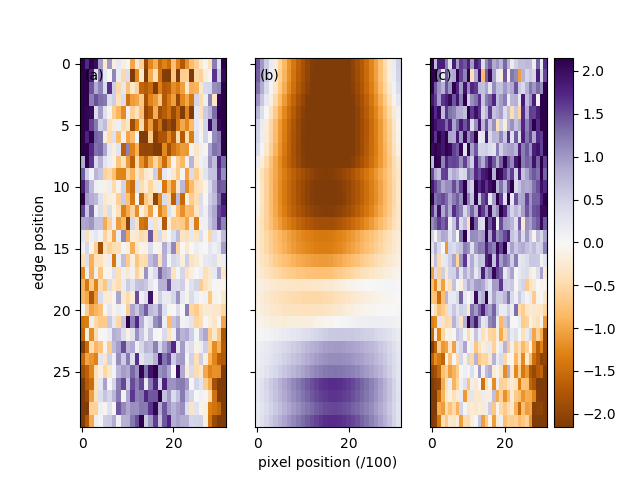

<IPython.core.display.Javascript object>


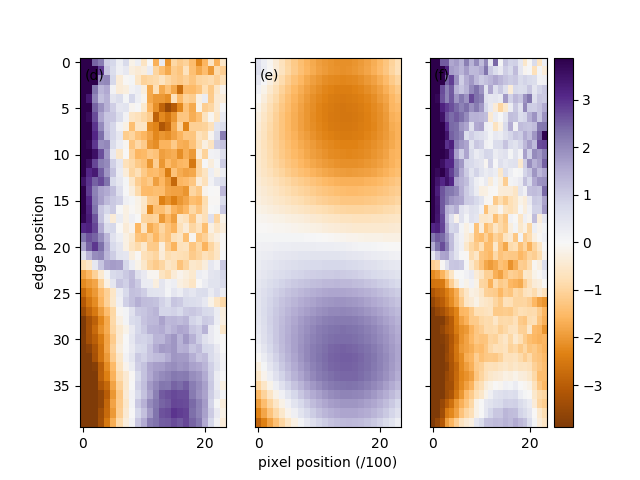

In [184]:
reduction = 100 # it makes sense to average pixels together quite aggressively

md = modelled_deviationss(res.x[:2], res.x[2:], liness)
for i, (deviations, modelled) in enumerate(zip(deviationss, md)):
    rdev = reduce_1d(deviations, reduction, axis=2)[:,i,:]
    assert np.all(np.abs(np.mean(deviations[:,i,:], axis=1)) < 0.01), "Means of rows in devations should be zero!!"
    rmdev = reduce_1d(modelled - np.mean(modelled, axis=1)[:,np.newaxis], reduction, axis=2)[:,i,:]
    vrange = np.percentile(np.abs(rdev), 95)
    fig, axes = plt.subplots(1,3, sharex=True, sharey=True)
    axes[0].imshow(rdev, aspect="auto", vmin=-vrange, vmax=vrange, cmap="PuOr")
    axes[1].imshow(rmdev, aspect="auto", vmin=-vrange, vmax=vrange, cmap="PuOr")
    im = axes[2].imshow(rdev-rmdev, aspect="auto", vmin=-vrange, vmax=vrange, cmap="PuOr")
    fig.colorbar(im)
    tidy_pixel_axes(axes, aspect=None, xlabel="pixel position (/{})".format(reduction), 
                    ylabel="edge position", part_number_offset=i*len(axes))
    